In [116]:
import time
import copy
import sys
from collections import OrderedDict
from collections import namedtuple
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import pickle
from collections import defaultdict
import math


from mpmath import mp
from scipy import optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm # for 3d poltting
from mpl_toolkits.mplot3d.axes3d import Axes3D # for 3d poltting
from sympy import symbols, cos, pi
from sympy.core.numbers import One
from sympy.utilities.lambdify import lambdify
from math import sin, pi

# Chebyshev Approximations!

In [117]:
class BasicSigmoids:
    @staticmethod
    def sigmoid(x, a, c):
        exponent = (-(x-a))/c
        denom = 1 + (math.e**(exponent))
        return 1/denom
    @staticmethod
    def square(x,a,b,c):
        s1=BasicSigmoids.sigmoid(x, a, c)
        s2=BasicSigmoids.sigmoid(x, b, -c)
        return s1*s2
    @staticmethod
    def scale_up(z,x_min,x_max):
        """
        Scales up z \in [-1,1] to x \in [x_min,x_max]
        where z = (2 * (x - x_min) / (x_max - x_min)) - 1
        """

        return x_min + (z + 1) * (x_max - x_min) / 2
    @staticmethod
    def scale_down(x,x_min,x_max):
        """
        Scales down x \in [x_min,x_max] to z \in [-1,1]
        where z = f(x) = (2 * (x - x_min) / (x_max - x_min)) - 1
        """    

        return (2 * (x - x_min) / (x_max - x_min)) - 1

class ChebyshevApproximator:
    def __init__(self, function, intr, deg, prec = 15, extra_shift=1.0):
        self.extra_shift = extra_shift
        n = deg + 1

        x, u = symbols('x u')

        a, b = intr
        x_to_u = (2 * x - a - b) / (b - a)
        u_to_x = (b - a) / 2 * u + (a + b) / 2
        chebyshev_nodes = cos((symbols('i') + 0.5) / n * pi)

        result_u = [chebyshev_nodes.evalf(prec, subs={'i': i}) for i in range(n)]
        result_x = [u_to_x.evalf(prec, subs={u: i}) for i in result_u]
        result_y = [function(i) for i in result_x]

        t = [One(), u]

        for _ in range(n - 2):
            t.append(2 * u * t[-1] - t[-2])

        c = [sum(result_y) / n]

        for index in range(1, n):
            c.append(2 * sum(t[index].evalf(prec, subs={u: i}) * j for i, j in zip(result_u, result_y)) / n)

        y = 1 * c[0]

        for i in range(1, n):
            y += t[i] * c[i]

        y = y.subs({u: x_to_u}).simplify()

        self.y = y        
        x, u = symbols('x u')    
        self.f = lambdify(x, self.y, "numpy")
        self.f.formula = y
    
    def _get_y(self):
        return self.y
    
    def __call__(self, x):
        return self.f(x)*self.extra_shift
    
    def get_coeffs(self):
        def cheby_to_coeff_list(s): 
            s_coeffs =  [((t.args[1].args[1] if (len(t.args[1].args) != 0)else 1), t.args[0]) for t in s.args[1:]] + [(0, s.args[0])]
            return [x[1] for x in sorted(s_coeffs)]

        return cheby_to_coeff_list(self.y)

class HatChebyshevApproximator(ChebyshevApproximator):
    def __init__(self,a,b,c = 0.005,deg = 10,left = -5,right = 5, extra_shift = 1.001):
        def hat(x):
            return BasicSigmoids.square(x,a,b,c)
        
        super().__init__(hat, (left,right),deg, prec=15, extra_shift=extra_shift)



## Data

In [372]:
#Configure GPU (change if not M1 mac)
mps = torch.device("mps")

In [373]:
# Datasets

# Using CIFAR-10 again as in the programming assignments
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Plotting Utilities

In [389]:
# Saving And helpers

def save_tracker(tracker, path):
  np.savetxt(path, tracker, delimiter=',') 

def save_trackers(device, filename):
  """Save all trackers and current total_time to a file."""
  torch.save((device['train_loss_tracker'], device['train_acc_tracker'], device['test_loss_tracker'], device['test_acc_tracker'], total_time), filename)
  print("Saved trackers to " + filename)

def moving_average(a, n=100):
  '''Helper function used for visualization'''
  ret = torch.cumsum(torch.Tensor(a), 0)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n
    
def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100, add_attack_region = None, alpha = .2):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  sample_tracker = list(trackers.items())[0][1]
  if add_attack_region is not None: 
      ax.fill_between(range(add_attack_region[0], add_attack_region[1]), 0, 100, alpha=alpha,  color='red')
  plt.show()

## ML / FL Utils (Largely borrowed from programming assigment 3)

In [375]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def iid_sampler(dataset, num_devices, data_pct):
    total_samples = len(dataset)
    sampled = {}
    number_samples = int((data_pct)*(total_samples)) 

    for i in range(num_devices):
      sampled[i] = random.sample(range(total_samples), number_samples)
        
    return sampled

In [122]:
# Neural net definitions

# Same ConvNet as in Assignment 2 and 3
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [123]:
def get_devices_for_round(devices, device_pct):  
    return random.sample(devices, int(device_pct * len(devices)))

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

def make_test_device(trainset):
    data_idxs = iid_sampler(trainset, 1, .1)
    return create_device(ConvNet().to(mps), 0, trainset, data_idxs[0]) 

In [124]:
# Local device training and testing
def train(epoch, device, criterion):
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(mps), targets.to(mps)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device, criterion, testloader = testloader):
    device['net'].eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)



## FL Simulation

In [376]:
# The baseline `average' function. 
def average_weights(devices,*args, **kwargs):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
        w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            w_avg[k] += (state_dicts[i][k].type(torch.float32))
        w_avg[k] /= float(len(devices))
    return w_avg

In [377]:
# Aggregation function tests (the main experiment routine)

# Given two different sets of aggregated weights, 
# gives a value representing the difference between them,
# as a way to measure the direct cost of using our aggregated function
def diff_aggregated_weights(strat, baseline):
    result = 0 
    for k in strat.keys():
        result += torch.linalg.norm(strat[k] - baseline[k])
    return result

# A data type for experiment results
BackdoorResult = namedtuple("BackdoorResult", ["scheme_loss", "test_accuracy", "backdoor_success", "devices", "avg_weight_history"])

def run_federated_test(agg_fn = average_weights,   # Pass in aggregation function, 
                                                   #     device list -> aggregated weights 
                       rounds = 10,                # Rounds of FL
                       local_epochs = 4,           # Epochs per device                      
                       num_devices = 50,           # Total # devices
                       device_pct = 0.2,           # % of devices per round
                       data_pct = 0.1,             # % of data each device gets
                       net = ConvNet().to(mps),    # Network object; make sure on mps backend
                       evil_round = None,          # integer list option; attacker will mount attack during these rounds
                       attacker_strategy = None,   # device -> void; Sets up attacker weight update on device 
                       evil_device_id = None,      # Which device id should perform the attack
                       evaluate_attack = None,     # Evaluated on the set of devices after each round and logged.
                       output_filename = None,     # Write results to disk at this path
                       snapshot = True,            # Snapshot to disk after each round
                       resume_from_snap = None,    # Optionally resume from a prior snapshot.
                       multiple_attack_rounds = [] # Specify multiple attack rounds instead of one, as above.
                      ):   
    '''
    Returns instance of BackdoorResult, with following state: 
        scheme_loss        : difference between a straight average and aggregated weights after each round
        test_accuracy      : classification accuracy after each round
        backdoor_success   : result of evaluate_attack(devices) after each round
        devices            : snapshot of devices after each round
        avg_weight_history : snapshot of central server weights after each round
    '''
    
    def lighten_device(d):
        return {
            k: d[k] for k in ( 'id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker')
        }                                   
    
    criterion = nn.CrossEntropyLoss()
    data_idxs = iid_sampler(trainset, num_devices, data_pct)

    devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]
    
    scheme_loss = []
    avg_weight_history = []
    _starting_round_num = 0
    
    if resume_from_snap: 
        print("Resuming from snapshot!\n")
        # Load what we can
        result = resume_from_snap
        scheme_loss = result.scheme_loss
        avg_weight_history = result.avg_weight_history
        partial_devices = result.devices

        # Fresh data and devices
        criterion = nn.CrossEntropyLoss()
        data_idxs = iid_sampler(trainset, num_devices, data_pct)

        devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]

        # Restore the devices with the info from the trackers
        def restore_device(old_device, new_device):
            for k in ('id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker'):
                new_device[k] = old_device[k]
            return new_device
        
        print("Restoring devices\n")
        devices = [restore_device(partial_devices[i], devices[i]) for i in range(len(devices))]
        for device in devices:
            device['net'].load_state_dict(avg_weight_history[-1])
        
        _starting_round_num = len(result.test_accuracy)
        print("Finished restoring\n")


        
    ## IID Federated Learning
    start_time = time.time()
    for round_num in range(_starting_round_num, rounds):
        round_start_time = time.time()
        # Part 1.3: Implement getting devices for each round here
        round_devices = get_devices_for_round(devices, device_pct)

        print('Round: ', round_num)
        # Train locally 
        for device in round_devices:
            for local_epoch in range(local_epochs):
                train(local_epoch, device, criterion)
        
        # One device becomes evil if required
        if ((evil_round and round_num == evil_round) or round_num in multiple_attack_rounds):
            assert (evil_device_id is not None)
            assert (attacker_strategy is not None)
            print("Attacking!\n")
            
            attacker_strategy(devices[evil_device_id])
            # Make sure evil guy gets averaged in 
            if evil_device_id not in round_devices:
                round_devices.append(devices[evil_device_id])
            print("Finished attacking\n")
            
        
        # Weight averaging
        w_baseline = average_weights(round_devices)
        w_avg = agg_fn(round_devices, (avg_weight_history[-1] if avg_weight_history != [] else None))
        
        # Track the difference between the two; should be 0 if straight average
        scheme_loss.append((float(diff_aggregated_weights(w_avg, w_baseline))))
        
        avg_weight_history.append(copy.deepcopy(w_avg))
        
        # Gradients         
        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # test accuracy after aggregation
        # device 0 is the unique device with all of the 
        # test accuracies and losses in its tracker
        test(round_num, devices[0], criterion)
        
        print(f"\nDiff: {scheme_loss[-1]}\n")
        print(f"Round time: {time.time() - start_time} \n")
        if snapshot:
            intermediate_result = BackdoorResult(
                scheme_loss = scheme_loss, 
                test_accuracy = devices[0]["test_acc_tracker"], 
                backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
                devices = [lighten_device(d) for d in devices], 
                avg_weight_history = avg_weight_history
            )


            if output_filename is not None: 
                print("Writing snapshot\n")
                with open(f"snapshot_{output_filename}", 'wb') as file: 
                    pickle.dump(intermediate_result, file)
        
    total_time = time.time() - start_time
    print('Total training time: {} seconds'.format(total_time))
    
    # Pack up everything we care about and the devices for good measure
    result = BackdoorResult(
        scheme_loss = scheme_loss, 
        test_accuracy = devices[0]["test_acc_tracker"], 
        backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
        devices = [lighten_device(d) for d in devices], 
        avg_weight_history = avg_weight_history
    )

    
    if output_filename is not None: 
        with open(output_filename, 'wb') as file: 
            print("Writing file\n")
            pickle.dump(result, file)
    
    return result


# Load output files back into memory
def load_result(filename):
    with open(filename, 'rb') as file: 
        return pickle.load(file)

In [378]:
# Example usage
# results = run_federated_test(local_epochs=1, num_devices = 10, rounds = 2, output_filename = "testout.pickle")
# # Can also load it back
# results = load_result("snapshot_testout.pickle")
# results

In [379]:
# Example 1 (Not real experiments; just to demonstrate usage)
# A silly attack that just sends massive weights all of magnitude 10000
def sample_attack(device):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    weights = device["net"].state_dict().copy()
    
    for w in weights.keys():
        weights[w] = torch.full(weights[w].size(), 10000)
    
    device['net'].load_state_dict(weights)
    
# A demo aggregation function that squashes any weights with magnitude over 1000 (except on the first device but whatever)
def super_smart_aggregation(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights, excluding huge updates.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
        w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            if (torch.max(state_dicts[i][k].type(torch.float32)) <= 1000): 
                w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg

# Here, we carry out the attack but use the ordinary average
results_straight_avg = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
                                         rounds = 3,              
                                         local_epochs = 1,                             
                                         num_devices = 10,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 1,        
                                         attacker_strategy = sample_attack,  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, 
                                         output_filename = "baseline_trivial_attack.pickle")  
# Observe that it absolutely destroys our model
# Now we do it again but with the aggregation that rejects huge updates
results_reject_huge = run_federated_test(agg_fn = super_smart_aggregation,                    
                                         rounds = 3,              
                                         local_epochs = 1,                             
                                         num_devices = 10,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 1,        
                                         attacker_strategy = sample_attack,  
                                         evil_device_id = 2,     
                                         evaluate_attack = None,
                                         output_filename = "simple_attack_and_defense.pickle")  

In [132]:
# Here, we compute a real baseline over 100 epochs and typical averaging. Good starting point for future 
# tests; can resume from this snapshot.
# baseline = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 100,              
#                                          local_epochs = 4,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline.pickle")  
baseline = load_result("baseline.pickle")
# For example, now can get things like
# baseline.test_accuracy

In [135]:
# We can resume from a snapshot:
# NOTE : keep all the basic params (local epochs, num devices, net, etc) the same
# when resuming from a snapshot 
baseline2 = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
                                         rounds = 101,              
                                         local_epochs = 4,                             
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evaluate_attack = None, 
                                         output_filename = "baseline2.pickle", 
                                         resume_from_snap = baseline )  # we pass in a results object here

## Defenses!

In [137]:
# Now we can move on to a real defense. 

# We create factory functions that let us parametrize a double sigmoid using threshholds
def torch_scaled_sigmoid_factory(a, c = 0.005, left = False):
    
    def f(x):
        scaled = torch.sub(x, a)
        divisor = c if left else -1*c
        scaled = torch.div(scaled, divisor)
        return torch.sigmoid(scaled)
    
    return f

# This is our paper's ``ideal'' hat function
def torch_double_sigmoid_factory(a,b,c = 0.005):
    left = torch_scaled_sigmoid_factory(a, left = True)
    right = torch_scaled_sigmoid_factory(b, left = False) 
    def f(x):
        return (left(x)*right(x))
    return f

my_sigmoid = torch_double_sigmoid_factory(-1,1)

In [138]:
torch_double_sigmoid_factory(-1,6)(torch.tensor(list(range(-5,10))))

In [139]:
# Make sure it works
torch_double_sigmoid_factory(-2,2)(torch.Tensor([-5,-4,-3,-2,-1.5,-1.4,1.3,-1,0,1,1.5,1.6,2,3,4]))

In [140]:
# Creates a sigmoid defense,
#     keys_to_range_mapping maps each layer name in the state dict to the sigmoid bounds for processing it
#     All other layers just get identity function-ed
#     Can provide the sigmoid function of your choice; this lets us switch to Cheby/minmax later
def make_sigmoid_defense(keys_to_range_mapping, stickiness = 0, sigmoid_function_on_ab = torch_double_sigmoid_factory):
    
    sigmoid_dict = defaultdict(lambda : (lambda x: 1))
    
    for k,(a,b) in keys_to_range_mapping.items():
        sigmoid_dict[k] = sigmoid_function_on_ab(a,b)
    
    def f(devices, previous_round_weights):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights preprocessed by sigmoid
        '''
        
        state_dicts = [device['net'].state_dict() for device in devices]
        sigmoid_result_per_device = [1]*len(devices)
        # initialize w_avg to tensors from device 0
        w_avg = copy.deepcopy(state_dicts[0])

        # get the sigmoids
        for i in range(len(devices)):
            for k in w_avg.keys():
                sig = sigmoid_dict[k]
                new_weight = (state_dicts[i][k].type(torch.float32))
                prev_round_x = previous_round_weights[k].type(torch.float32)  if (previous_round_weights is not None) else new_weight
                r = sig(torch.sub(new_weight, prev_round_x))
                sigmoid_result_per_device[i] *= ((torch.mean(r) if (type(r) not in [int, float]) else r)**5)
        
        for k in w_avg.keys():
            sig = sigmoid_dict[k]
            new_weight = w_avg[k].type(torch.float32)
            w_avg[k] = new_weight*sigmoid_result_per_device[0]
            
            prev_round_x = previous_round_weights[k].type(torch.float32)  if (previous_round_weights is not None) else new_weight
            for i in range(stickiness):
                w_avg[k] += prev_round_x            

        # for each model param
        for k in w_avg.keys():
            # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k], scaling by sig
            for i in range(1, len(devices)):
                new_weight = (state_dicts[i][k].type(torch.float32))
                w_avg[k] += new_weight*sigmoid_result_per_device[i]
                
            # compute average
            w_avg[k] /= float(sum(sigmoid_result_per_device) + stickiness)
        return w_avg
    
    return f

In [141]:
# These are the actual layer weights that we care about
[x for x in baseline.avg_weight_history[-1].keys() if '.0.weight' in x]

['model.0.0.weight',
 'model.1.0.weight',
 'model.2.0.weight',
 'model.3.0.weight',
 'model.4.0.weight',
 'model.5.0.weight',
 'model.6.0.weight',
 'model.7.0.weight',
 'model.8.0.weight']

In [142]:
# Now lets set up a potential sigmoid defense
empirical_cutoffs = {
    'model.0.0.weight' : (-1,1),
    'model.1.0.weight' : (-0.3,0.3),
    'model.2.0.weight' : (-0.3,0.3),
    'model.3.0.weight' : (-0.3,0.3),
    'model.4.0.weight' : (-0.3,0.3),
    'model.5.0.weight' : (-0.3,0.3),
    'model.6.0.weight' : (-0.3,0.3),
    'model.7.0.weight' : (-0.1,0.1),
    'model.8.0.weight' : (-0.1,0.1),
}
sigmoid_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0, sigmoid_function_on_ab=HatChebyshevApproximator)

## Attacks!

In [144]:
# Now lets make an real attack
# Makes an attack that puts noise in all of target layers. 
# Noise is uniform over a,b
def noise_attack_factory(target_layers, a,b):
    def attack(device):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        weights = device["net"].state_dict().copy()

        for w in weights.keys():
            if w in target_layers:
                weights[w] = (a - b) * torch.rand(weights[w].size()) + b

        device['net'].load_state_dict(weights)
    return attack

In [154]:
# Utilities for the swap classes attack
def swap_classes_dataset(s, a, b):
    s = list(s)
    for i in range(len(s)):
        if s[i][1] == a:
            s[i] = s[i][0],b
        elif s[i][1] == b:
            s[i] = s[i][0],a 
    
    return s

def limit_test_set(s, labels):
    s = list(s)
    s = [s for s in s if s[1] in labels]
    return s


# Make switch classes attack
def switch_classes_attack(a,b, train_epochs):
    transform_train = transforms.Compose([                                   
        transforms.RandomCrop(32, padding=4),                                       
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    evil_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                            download=True,
                                            transform=transform_train)
    print(len(evil_trainset))


    evil_trainset = swap_classes_dataset(evil_trainset, a,b)
    print(len(evil_trainset))


    print("swapping and limiting\n")
    
    # Load testing data
    transform_test = transforms.Compose([                                           
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    
    evil_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True,
                                           transform=transform_test)
    evil_testset = limit_test_set(evil_testset, [a,b])

    
    evil_testset = swap_classes_dataset(evil_testset, a,b)
    
    evil_testloader = torch.utils.data.DataLoader(evil_testset, batch_size=128, shuffle=False)
    
    attack_idx = iid_sampler(evil_trainset, 1, 1)[0]
    
    
    
    evil_device_trainset = DatasetSplit(evil_trainset, attack_idx)
    evil_device_trainloader = torch.utils.data.DataLoader(evil_device_trainset,
                                                     batch_size=128,
                                                     shuffle=True)

    criterion = nn.CrossEntropyLoss()
    
    logged_state_dict = None

    class attack_class:
        def __init__(self):
            self.logged_state_dict = None
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        def __call__(self, device):
            device['dataloader'] = evil_device_trainloader

            if self.logged_state_dict is not None:
                print("Using memoized attack\n")
                device['net'].load_state_dict(self.logged_state_dict)
            else:
                for local_epoch in range(train_epochs):
                    train(local_epoch, device, criterion)
                    test(0, device, criterion,testloader =  evil_testloader)


            print("Confirm the attack worked. (This should be high)")  
            test(0, device, criterion,testloader =  evil_testloader)


            self.logged_state_dict = copy.deepcopy(device['net'].state_dict())

    return attack_class()

In [ ]:
# Now let's make an instance of this attack that performs 25 epochs of training on the evil device with the misclassified data.
# Specifically, we switch cars and airplanes
sca_01 = switch_classes_attack(0,1,25)

## Finally, time for the experiments!

In [ ]:
def limit_test_set(s, labels):
    s = list(s)
    s = [s for s in s if s[1] in labels]
    return s


def make_testloader_subset(labels, a, b):
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
    
    restricted_test_set = limit_test_set(testset, labels)
    restricted_test_set = swap_classes_dataset(restricted_test_set, a, b)
    
    restricted_testloader = torch.utils.data.DataLoader(restricted_test_set, batch_size=128, shuffle=False)
    
    return restricted_testloader

# A tool used to help us find the empirical cutoffs (experimenting around not present in this notebook. )
def weight_history_to_layer_max_magnitude_and_means(w_avg, include_batch_norm = True):
    weight_keys = [x for x in w_avg.keys() if ".0.weight" in x]
    if include_batch_norm:
        weight_keys += [x for x in w_avg.keys() if ".1.weight" in x]
    def max_magnitude(t):
        return torch.max(torch.abs(t))
    def mean_magnitude(t):
        return torch.mean(torch.abs(t))
    all_means = [mean_magnitude(w_avg[w]) for w in weight_keys]
    all_max = [max_magnitude(w_avg[w]) for w in weight_keys]
    return all_means, all_max

In [ ]:
# baseline = load_result("baseline.pickle")
# switch_classes_no_defense = run_federated_test(                    
#                                          rounds = 130, # go 30 pounds past where the baseline left off              
#                                          local_epochs = 4,  # all else the same                     
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 110, # attack after 10 rounds more training with the new acc fn        
#                                          attacker_strategy = sca2, # device 2 will carry out big noise attack  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None, # we will evaluate manually afterwards 
#                                          output_filename = "switch_classes_no_defense.pickle",
#                                          resume_from_snap = baseline, # pick up where baseline left off  
#                                          snapshot = True ) # 

In [ ]:
sca_zero_one = switch_classes_attack(0,1,25)
baseline = load_result("baseline.pickle")
switch_classes_no_defense = run_federated_test(                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_no_defense_multiple_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109]) # 

In [344]:
sca_zero_one = switch_classes_attack(0,1,25)

Files already downloaded and verified
50000
50000
swapping and limiting

Files already downloaded and verified


In [ ]:
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense_actually_train = run_federated_test(  agg_fn = sigmoid_aggregation, 
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.02,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final_scratch_actually_train.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109, 110]) # 

In [ ]:
switch_classes_no_defense.avg_weight_history[-1]

In [ ]:
# sca_zero_one = switch_classes_attack(0,1,2)
baseline = load_result("baseline.pickle")
switch_classes_no_defense_fixed_2 = run_federated_test(                    
                                         rounds = 150, # go 30 pounds past where the baseline left off              
                                         local_epochs = 1,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.02,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_no_defense_multiple_final_fixed_2.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = False, 
                                         multiple_attack_rounds = (list(range(100,130)))) # 

In [300]:
switch_classes_no_defense_fixed = load_result("switch_classes_no_defense_multiple_final_fixed.pickle")

In [ ]:
empirical_cutoffs = {
    'model.0.0.weight' : (-0.01,0.01),
    'model.1.0.weight' : (-0.01,0.01),
    'model.2.0.weight' : (-0.01,0.01),
    'model.3.0.weight' : (-0.01,0.01),
    'model.4.0.weight' : (-0.01,0.01),
    'model.5.0.weight' : (-0.01,0.01),
    'model.6.0.weight' : (-0.01,0.01),
    'model.7.0.weight' : (-0.01,0.01),
    'model.8.0.weight' : (-0.01,0.01),
}
all_keys   = [x for x in baseline.avg_weight_history[-1].keys() if ".weight" in x]
test_cutoffs = {
    x : (-0.01,0.01)
    for x in all_keys
}

sigmoid_aggregation = make_sigmoid_defense(test_cutoffs, stickiness=0)

# sca_zero_one = switch_classes_attack(0,1,2)
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense_fixed = run_federated_test(  agg_fn=sigmoid_aggregation,                
                                         rounds = 150, # go 30 pounds past where the baseline left off              
                                         local_epochs = 0,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.4,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final_fixed.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = False, 
                                         multiple_attack_rounds = (list(range(100,130)))) # 

## Plots!

In [383]:
# Creates a function that extracts the data we need to make the plots about attacks that 
# switch a pair of classes (a,b)
def make_evaluate_switch_classes_attack_weights(a, b):
    checker_test_set_nontarget = make_testloader_subset([x for x in list(range(10)) if x not in [a,b]], 0, 0)
    checker_test_set_target = make_testloader_subset([a,b], a, b)
    
    def f(w):
        test_device = make_test_device(trainset)
        test_device['net'].load_state_dict(w)

        test(0, test_device, nn.CrossEntropyLoss(), checker_test_set_nontarget)
        nontarget_accuracy = test_device['test_acc_tracker'][-1]
        test(0, test_device, nn.CrossEntropyLoss(), checker_test_set_target)
        target_accuracy = test_device['test_acc_tracker'][-1]
        return nontarget_accuracy, target_accuracy
    return f 

In [ ]:
# For example, we can load in some data and split it into classes as needed. 
no_defense_switch_classes = load_result("switch_classes_no_defense_multiple_final_fixed_2.pickle")
evaluate_switch_classes_attack_weights = make_evaluate_switch_classes_attack_weights(0,1)
d = [evaluate_switch_classes_attack_weights(no_defense_switch_classes.avg_weight_history[r]) for r in range(len(no_defense_switch_classes.avg_weight_history))]

In [ ]:
# Let's load in our other final data for the noise experiments
sigmoid_against_noise = load_result("sigmoid_against_noise_attack_final.pickle")
no_defense_noise = load_result("noise_attack_1_no_defense.pickle")
s6 = load_result("noise_attack_cheby_deg_6.pickle")
s10 = load_result("noise_attack_cheby_deg_10.pickle")

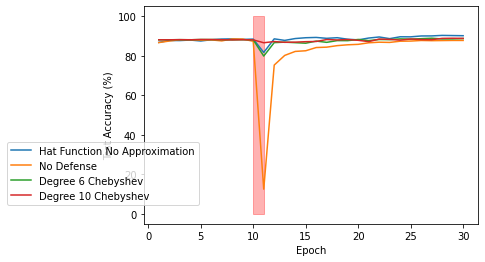

In [384]:
# Now we can make the plot!
noise_data_elts = {
    "Hat Function No Approximation" : sigmoid_against_noise.test_accuracy[100::],   
    "No Defense" : no_defense_noise.test_accuracy[100:],
    "Degree 6 Chebyshev" : s6.test_accuracy[90:120],
    "Degree 10 Chebyshev" : s10.test_accuracy[90:120]
}
make_plot_better(tracks2, 30, title="", y_axis_lab="Test Accuracy (%)", should_average=False,  add_attack_region =(10,12), n=0, alpha = .3)

In [173]:
cheby_training = load_result("cheby_training_scratch_stricter.pickle")

In [175]:
tracks_training = {
    "No Defense" : baseline.test_accuracy[:50],   
    "Degree 10 Chebyshev" : cheby_training.test_accuracy[:50]
}

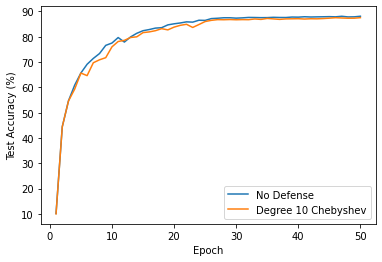

In [256]:
make_plot_better(tracks_training, 50, title="", y_axis_lab="Test Accuracy (%)", should_average=False, n=0, alpha = .3)

In [ ]:
evaluate_switch_classes_attack_weights = make_evaluate_switch_classes_attack_weights(0,1)
d = [evaluate_switch_classes_attack_weights(switch_classes_sigmoid_defense_actually_train.avg_weight_history[r]) for r in range(len(switch_classes_sigmoid_defense_actually_train.avg_weight_history))]

In [200]:
no_defense_switch_classes = load_result("switch_classes_no_defense_sat_2.pickle")
degree_10_switch_classes = load_result("sca_attack_cheby_deg_10_bigger.pickle")
degree_6_switch_classes = load_result("sca_attack_cheby_deg_6_bigger.pickle")

In [201]:
evaluate_switch_classes_attack_weights = make_evaluate_switch_classes_attack_weights(0,1)
def eval_attack_over_weight_history(x, start = 0):
    return [evaluate_switch_classes_attack_weights(x.avg_weight_history[r]) for r in range(start, len(x.avg_weight_history))]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
no_def_evaluate = eval_attack_over_weight_history(no_defense_switch_classes, 90)

In [ ]:
degree_6_evaluate = eval_attack_over_weight_history(degree_6_switch_classes, 90)

In [ ]:
degree_10_evaluate = eval_attack_over_weight_history(degree_10_switch_classes, 90)

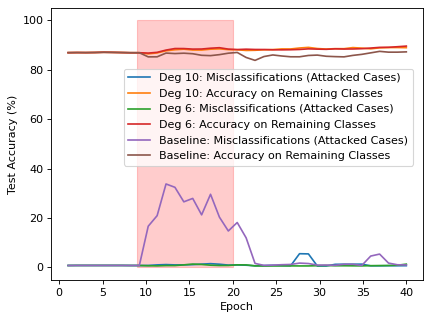

In [388]:
switch_classes_attack_data = {
    "Deg 10: Misclassifications (Attacked Cases)" : [x[1] for x in degree_10_evaluate],   
    "Deg 10: Accuracy on Remaining Classes" : [x[0] for x in degree_10_evaluate],
    "Deg 6: Misclassifications (Attacked Cases)" : [x[1] for x in degree_6_evaluate],   
    "Deg 6: Accuracy on Remaining Classes" : [x[0] for x in degree_6_evaluate],
    "Baseline: Misclassifications (Attacked Cases)" : [x[1] for x in no_def_evaluate],   
    "Baseline: Accuracy on Remaining Classes" : [x[0] for x in no_def_evaluate]
}
from matplotlib.pyplot import figure
figure(figsize=(6, 4.5), dpi=80)
make_plot_better(switch_classes_attack_data, 40, title="", y_axis_lab="Test Accuracy (%)", should_average=True,  add_attack_region =(9,21), n=2)

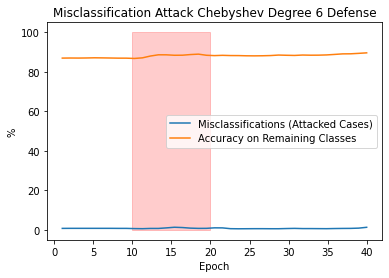

In [221]:
degree_6_tracks = {
    "Misclassifications (Attacked Cases)" : [x[1] for x in degree_6_evaluate],   
    "Accuracy on Remaining Classes" : [x[0] for x in degree_6_evaluate]
}
make_plot_better(degree_6_tracks, 40, title="Misclassification Attack Chebyshev Degree 6 Defense", y_axis_lab="%", should_average=True,  add_attack_region =(10,21), n=2)

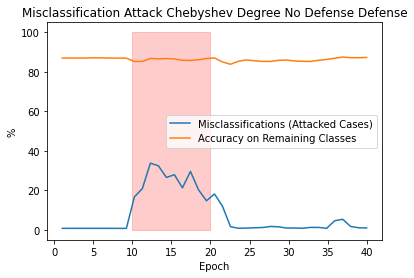

In [279]:
no_def_tracks = {
    "Misclassifications (Attacked Cases)" : [x[1] for x in no_def_evaluate],   
    "Accuracy on Remaining Classes" : [x[0] for x in no_def_evaluate]
}
make_plot_better(no_def_tracks, 40, title="Misclassification Attack Chebyshev Degree No Defense Defense", y_axis_lab="%", should_average=True,  add_attack_region =(10,21), n=2)

In [ ]:
target_layers = ['model.0.0.weight',
 'model.1.0.weight',
 'model.2.0.weight',
 'model.3.0.weight',
 'model.4.0.weight',
 'model.5.0.weight',
 'model.6.0.weight',
 'model.7.0.weight',
 'model.8.0.weight']
big_noise_attack = noise_attack_factory(target_layers,-0.4,0.4)

empirical_cutoffs = {
    'model.0.0.weight' : (-1.5,1.5),
    'model.1.0.weight' : (-0.5,0.5),
    'model.2.0.weight' : (-0.5,0.5),
    'model.3.0.weight' : (-0.5,0.5),
    'model.4.0.weight' : (-0.5,0.5),
    'model.5.0.weight' : (-0.5,0.5),
    'model.6.0.weight' : (-0.5,0.5),
    'model.7.0.weight' : (-0.5,0.5),
    'model.8.0.weight' : (-0.5,0.5),
}
cheby_10_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0, sigmoid_function_on_ab=HatChebyshevApproximator)

baseline = load_result("baseline.pickle")
noise_attack_cheby_10 = run_federated_test( agg_fn = cheby_10_aggregation,                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.1,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = None, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = big_noise_attack, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         output_filename = "noise_attack_cheby_deg_10.pickle",
                                         multiple_attack_rounds=[100]) # 

In [ ]:
empirical_cutoffs = {
    'model.0.0.weight' : (-1.5,1.5),
    'model.1.0.weight' : (-0.5,0.5),
    'model.2.0.weight' : (-0.5,0.5),
    'model.3.0.weight' : (-0.5,0.5),
    'model.4.0.weight' : (-0.5,0.5),
    'model.5.0.weight' : (-0.5,0.5),
    'model.6.0.weight' : (-0.5,0.5),
    'model.7.0.weight' : (-0.5,0.5),
    'model.8.0.weight' : (-0.5,0.5),
}
cheby_6_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0, sigmoid_function_on_ab=(lambda a,b: HatChebyshevApproximator(a,b,deg=6)))

baseline = load_result("baseline.pickle")
noise_attack_cheby_6 = run_federated_test( agg_fn = cheby_6_aggregation,                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.1,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = None, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = big_noise_attack, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         output_filename = "noise_attack_cheby_deg_6.pickle",
                                         multiple_attack_rounds=[100]) # 

In [ ]:

empirical_cutoffs = {
    'model.0.0.weight' : (-1.5,1.5),
    'model.1.0.weight' : (-0.5,0.5),
    'model.2.0.weight' : (-0.5,0.5),
    'model.3.0.weight' : (-0.5,0.5),
    'model.4.0.weight' : (-0.5,0.5),
    'model.5.0.weight' : (-0.5,0.5),
    'model.6.0.weight' : (-0.5,0.5),
    'model.7.0.weight' : (-0.5,0.5),
    'model.8.0.weight' : (-0.5,0.5),
}
cheby_10_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0, sigmoid_function_on_ab=HatChebyshevApproximator)
sca_zero_one = switch_classes_attack(0,1,25)


baseline = load_result("baseline.pickle")
sc_attack_cheby_10 = run_federated_test(  agg_fn = cheby_10_aggregation, 
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.02,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "sca_attack_cheby_deg_10.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109, 110]) #

In [ ]:
empirical_cutoffs = {
    'model.0.0.weight' : (-1.5,1.5),
    'model.1.0.weight' : (-0.5,0.5),
    'model.2.0.weight' : (-0.5,0.5),
    'model.3.0.weight' : (-0.5,0.5),
    'model.4.0.weight' : (-0.5,0.5),
    'model.5.0.weight' : (-0.5,0.5),
    'model.6.0.weight' : (-0.5,0.5),
    'model.7.0.weight' : (-0.5,0.5),
    'model.8.0.weight' : (-0.5,0.5),
}
cheby_6_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0, sigmoid_function_on_ab=(lambda a,b: HatChebyshevApproximator(a,b,deg=6)))

# sca_zero_one = switch_classes_attack(0,1,25)


baseline = load_result("baseline.pickle")
sc_attack_cheby_6 = run_federated_test(  agg_fn = cheby_6_aggregation, 
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.02,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "sca_attack_cheby_deg_6.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109, 110]) #

In [ ]:
empirical_cutoffs = {
    'model.0.0.weight' : (-1.5,1.5),
    'model.1.0.weight' : (-0.5,0.5),
    'model.2.0.weight' : (-0.5,0.5),
    'model.3.0.weight' : (-0.5,0.5),
    'model.4.0.weight' : (-0.5,0.5),
    'model.5.0.weight' : (-0.5,0.5),
    'model.6.0.weight' : (-0.5,0.5),
    'model.7.0.weight' : (-0.5,0.5),
    'model.8.0.weight' : (-0.5,0.5),
}
cheby_10_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0, sigmoid_function_on_ab=HatChebyshevApproximator)

# baseline = load_result("baseline.pickle")
cheby_training_scratch = run_federated_test( agg_fn = cheby_10_aggregation,                    
                                         rounds = 50, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.1,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = None, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = None, # device 2 will carry out big noise attack  
                                         evil_device_id = None,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         snapshot = True, 
                                         output_filename = "cheby_training_scratch.pickle",) # 